# Shuttle Dataset

In [8]:
# Import packages
from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_keep_axes, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
from sklearn import model_selection
from scipy import stats
from sklearn import svm
from sklearn import tree
import pandas as pd
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# class label = sex
def loadData_shuttle(dataset_size=58000):
    dataset1 = pd.read_csv('Datasets/shuttle.trn', header=None,sep='\s')
    dataset2 = pd.read_csv('Datasets/shuttle.tst', header=None,sep='\s')
    dataset = np.concatenate((dataset1, dataset2))
    y = dataset[:,-1] == 1
    isInB = np.array([dataset[i,0]>54.5 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset[:,0:-1]
    X = np.append(X, isInB, axis=1)
    
    # draw sample
    X, _, y, _ = model_selection.train_test_split(X, y, test_size=0.8)
    
    return X, y

[Text(167.4, 163.07999999999998, 'X[0] <= 54.5\ngini = 0.336\nsamples = 58000\nvalue = [12414, 45586]'),
 Text(83.7, 54.360000000000014, 'gini = 0.011\nsamples = 41779\nvalue = [221, 41558]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.373\nsamples = 16221\nvalue = [12193, 4028]')]

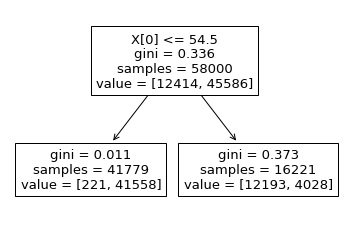

In [34]:
# quick check for the most predictive attribute:
X, y = loadData_shuttle()
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X[:,0:len(X[0])-1],y)
tree.plot_tree(clf) 

In [3]:
# remove all mushrooms with rings <= 8
def bias_shuttle(data, labels):
    isInB = data[:,-1]
    X = data[isInB==1]
    X = X[:, 0:(len(data[0])-1)]
    y = labels[isInB==1]
    return X, y

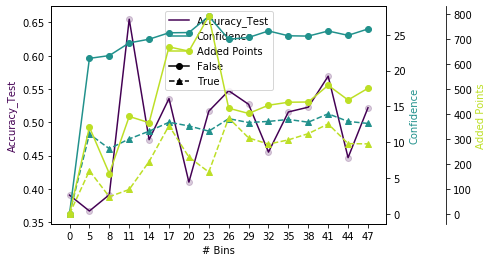

In [4]:
data_gen = loadData_shuttle
bias_gen = bias_shuttle
#trafo = lambda: trafo_ica(21)
#DE = lambda b: DE_kde(num_bins=b, kernel='gau')
DE = DE_histogram
bh = IMITATE(list(range(5,50,3)), bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
bh.run(False, False, False)

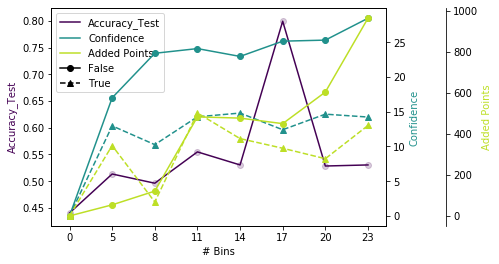

In [4]:
data_gen = loadData_shuttle
bias_gen = bias_shuttle
#trafo = lambda: trafo_ica(21)
DE = lambda b: DE_kde(num_bins=b, kernel='gau')
#DE = DE_histogram
bh = IMITATE(list(range(5,25,3)), bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
bh.run(False, False, False)

## INCOMPLETE case: we remove the attribute that was used to generate the bias

In [5]:
def run_experiment(num_bins, model, repeat=10):
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    data_gen = loadData_shuttle
    bias_gen = bias_shuttle
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, model=model, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=10, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

In [6]:
def run_and_eval(runs=10, model=svm.SVC(kernel='linear')):
    acc_init = np.zeros(runs)
    acc_final = np.zeros(runs)
    hist_bins = list(range(10,20,1))
    
    for r in range(runs):
        bh = run_experiment(hist_bins, model=model, repeat=2)
        acc_init[r] = bh.D.acc_unbiased - bh.D.acc_init
        acc_final[r] = bh.D.acc_unbiased - bh.D.accuracyBiased(bh.added_points, bh.added_labels)
        print("run", r, "- acc_i =", acc_init[r], " acc_f =", acc_final[r])

    return acc_init, acc_final

### Linear SVM

In [7]:
res = run_and_eval()

run 0 - acc_i = 0.5862068965517241  acc_f = 0.5172413793103448
run 1 - acc_i = 0.6531609195402299  acc_f = 0.4002873563218391
run 2 - acc_i = 0.6356321839080459  acc_f = 0.4114942528735631
run 3 - acc_i = 0.6293103448275863  acc_f = 0.4770114942528736
run 4 - acc_i = 0.6301724137931035  acc_f = 0.5005747126436781
run 5 - acc_i = 0.6425287356321839  acc_f = 0.5908045977011495
run 6 - acc_i = 0.6014367816091954  acc_f = 0.49770114942528737
run 7 - acc_i = 0.5933908045977012  acc_f = 0.5017241379310344
run 8 - acc_i = 0.6051724137931034  acc_f = 0.4589080459770115
run 9 - acc_i = 0.4939655172413793  acc_f = 0.30632183908045985


In [9]:
np.average(res, axis=1)

array([0.6070977, 0.4662069])

In [10]:
stats.ttest_ind(res[0], res[1])

Ttest_indResult(statistic=4.936471684578076, pvalue=0.00010654621096911486)

### Decision Tree

In [11]:
model = tree.DecisionTreeClassifier
res_tree = run_and_eval(model=model)

run 0 - acc_i = 0.6160919540229886  acc_f = 0.6011494252873564
run 1 - acc_i = 0.5962643678160919  acc_f = 0.478735632183908
run 2 - acc_i = 0.592816091954023  acc_f = 0.5
run 3 - acc_i = 0.6206896551724138  acc_f = 0.46896551724137936
run 4 - acc_i = 0.5902298850574713  acc_f = 0.4494252873563218
run 5 - acc_i = 0.6425287356321838  acc_f = 0.5045977011494253
run 6 - acc_i = 0.6497126436781608  acc_f = 0.6445402298850574
run 7 - acc_i = 0.5925287356321839  acc_f = 0.5126436781609196
run 8 - acc_i = 0.17931034482758623  acc_f = 0.2206896551724138
run 9 - acc_i = 0.5836206896551724  acc_f = 0.44367816091954027


In [12]:
np.average(res_tree, axis=1)

array([0.56637931, 0.48244253])

In [13]:
stats.ttest_ind(res_tree[0], res_tree[1])

Ttest_indResult(statistic=1.4928811737951815, pvalue=0.1527892986115489)

### SVM with RBF kernel

In [14]:
model = svm.SVC(kernel='rbf')
res_rbf = run_and_eval(model=model)

run 0 - acc_i = 0.6002873563218392  acc_f = 0.5798850574712644
run 1 - acc_i = 0.6086206896551725  acc_f = 0.4905172413793104
run 2 - acc_i = 0.6204022988505747  acc_f = 0.1775862068965517
run 3 - acc_i = 0.5988505747126436  acc_f = 0.4267241379310345
run 4 - acc_i = 0.5922413793103449  acc_f = 0.5137931034482759
run 5 - acc_i = 0.6048850574712643  acc_f = 0.38160919540229876
run 6 - acc_i = 0.5991379310344828  acc_f = 0.27155172413793105
run 7 - acc_i = 0.49224137931034484  acc_f = 0.39885057471264374
run 8 - acc_i = 0.5942528735632184  acc_f = 0.4252873563218391
run 9 - acc_i = 0.5922413793103448  acc_f = 0.5787356321839081


In [15]:
np.average(res_rbf, axis=1)

array([0.59031609, 0.42445402])

In [16]:
stats.ttest_ind(res_rbf[0], res_rbf[1])

Ttest_indResult(statistic=3.9526902049821335, pvalue=0.0009331679928841993)